This script will show how to do affine align on given data.     


___
Part 1, show the usage of in-build atlas 

In [1]:
from Brain_Atlas.Atlas_Mask import Mask_Generator
from Align_Tools import Match_Pattern

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import Common_Functions as cf



Mask Generator have in-build mask atlas, in which we use allen mice brain atlas.   
This will provide you the mask of each brain area, and the mask of all area.    
bin = 1,2,4 is avaliable, bin 1 in shape 1320x1140.

(330, 285)


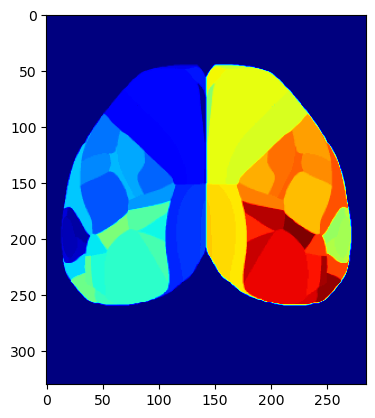

In [2]:
MG = Mask_Generator(bin=4) # bin is the only parameter you need.
plt.imshow(MG.idmap,cmap='jet')
print(MG.idmap.shape)

What area do you want? you can look it up in: **Brain_Atlas\Brain_Areas**    
This function give you the name list easily.

In [3]:
visible_areas = MG.all_areas
print(visible_areas)

['ACAd', 'AUDp', 'SSp-ul', 'MOp', 'VISli', 'AUDv', 'AUDd', 'AUDpo', 'SSp-tr', 'MOs', 'PL', 'VISl', 'VISa', 'VISpl', 'VISpor', 'SSp-ll', 'RSPagl', 'VISp', 'VISrl', 'SSp-n', 'SSs', 'VISal', 'TEa', 'VISpm', 'SSp-bfd', 'SSp-un', 'SSp-m', 'FRP', 'RSPd', 'RSPv', 'VISam']


Use this you can get mask of specific brain area, you only need to provide name and hemisphare

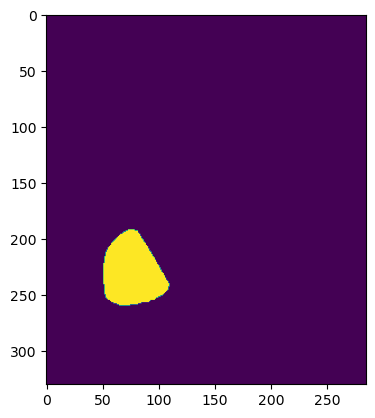

In [4]:
v1_mask = MG.Get_Mask(area='VISp',LR='L')
plt.imshow(v1_mask)

Alaternatively, you can give a pixel, we can return the brain area you selected.

In [5]:
pix = (180,55)# attention, in sequence Y,X, also remember the bin.
name,hemi = MG.Pix_Label(y = pix[0],x = pix[1])
print(f'Pixel {pix} on hemishpere {hemi}, located at area {name}')

Pixel in area SSp-bfd, on hemisphere L
Pixel (180, 55) on hemishpere L, located at area SSp-bfd


___
Part 2, example of how to do an affine align.

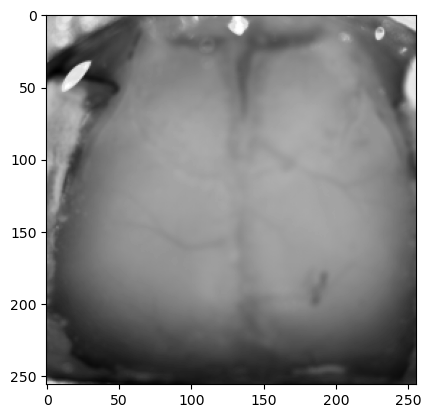

In [6]:
wp = r'D:\ZR\_Data_Temp\Ois200_Data\Affine_Data\241220Run06'
raw_r = np.load(cf.join(wp,'bin_R.npy'))
raw_r.shape
avr = raw_r.mean(0)
plt.imshow(avr,cmap='gray')

We can transfer data to standard space.   
bin will determine the scale of space after transform. Usually we keep shape similar.   
bin=4 for 256x256, bin=2 for 512x512.

After Align Resolution:330x285
Selecting Bregma..
Selecting Lambda..
Selecting Other Points..
Continuing with the process...
Select points saved in self.anchor


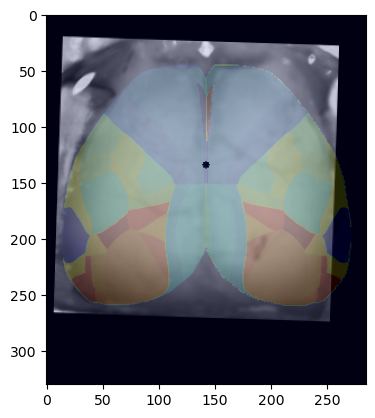

In [7]:
MP = Match_Pattern(avr = avr,bin=4)
MP.Select_Anchor()# this function will select points in interactive GUI. These points determine the transformation.
# fit after anchor selection. Do this repeatly untill you are satisfied.
MP.Fit_Align_Matrix()

We use bregma-lambda-distance as 4.2mm to rescale the graph.   
We use all 5 point to get middle line.   
We use bregma location as origin.  
     
***Current version might have bug on upside-down graph. Inform me if bug occured.***

[114 136]
30.000000000000018
-1.909152432996379


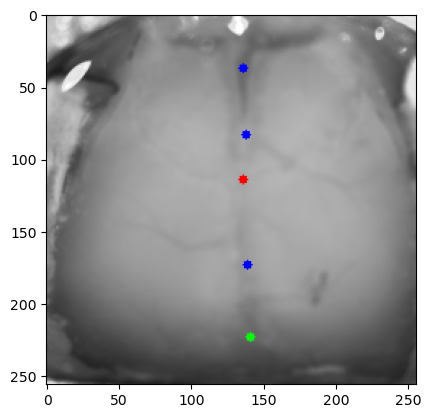

In [11]:
# here are parameters and graphs you ca
plt.imshow(MP.point_demo,cmap='gray')
print(MP.realbreg) # bregma location of your selection.
print(MP.slope) # slope of middle-line 
print(MP.rot_angle) # angles of rotation, negative value means anti-clockwise.

If you are satisfied with align parameter, it's possible to transform graph stacks to standard space.   
This operation is a little slow.

In [12]:
transformed_stacks = MP.Transform_Series(stacks=raw_r)
savepath = r'D:\ZR\_Data_Temp\Ois200_Data\Affine_Data\241220Run06'
np.save(cf.join(savepath,'Transformed_R_Series.npy'),transformed_stacks)
print(transformed_stacks.shape)

100%|██████████| 18000/18000 [01:36<00:00, 185.62it/s]


(18000, 330, 285)


After transform, you can use standard id to call brain areas.   
We recommend also use a chamber mask.     
dtype is 'uint16', resolution 330x285 for bin 4    

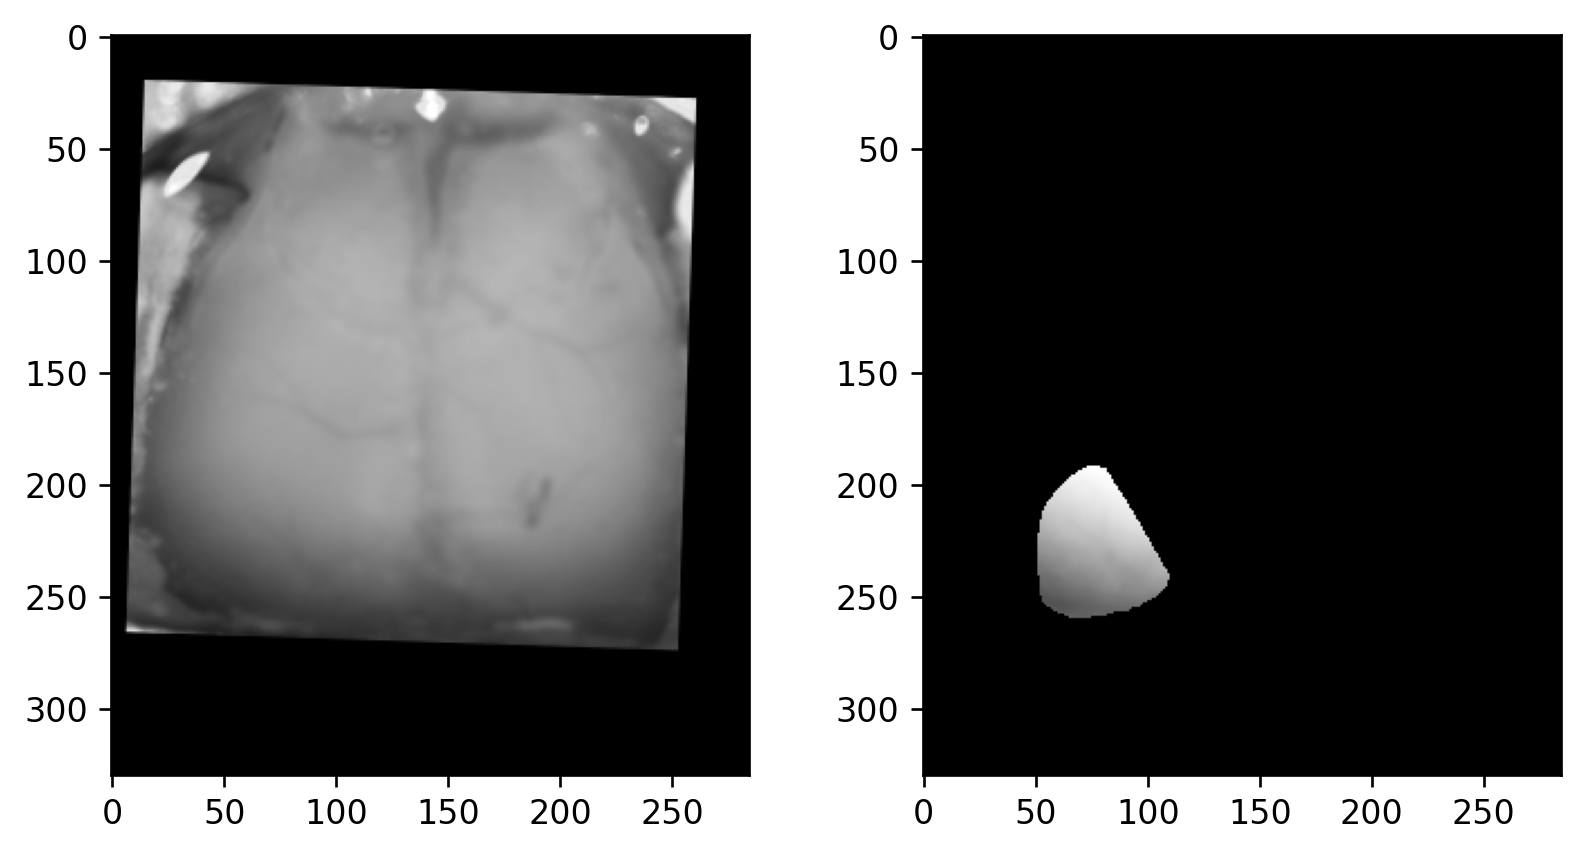

In [16]:

fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (8,4),dpi=240)
ax[0].imshow(transformed_stacks.mean(0),cmap='gray')

# you can also use mask to get specific brain area data.
v1_l = MG.Get_Mask(area='VISp',LR='L')
ax[1].imshow(transformed_stacks.mean(0)*v1_l,cmap='gray')


___
Part 3, demo of a easy seed point correlation.    
We try a seed point correlation.

In [25]:
demo_series = transformed_stacks[5000:6000,:,:]
from Signal_Functions.Filters import  Signal_Filter_1D
from tqdm import tqdm

height = 330
width = 285

HP_freq = 0.005
LP_freq = 1
fps = 4
r_filted = np.zeros(shape = (len(demo_series),height,width),dtype='f8')
for i in tqdm(range(height)):
    for j in range(width):
        x = demo_series[:,i,j]
        if x.sum() == 0:
            continue # ignore all-0 series.
        filted_x = Signal_Filter_1D(x,HP_freq,LP_freq,fps)
        r_filted[:,i,j] = filted_x
r_filted.shape


100%|██████████| 330/330 [01:25<00:00,  3.86it/s]


(1000, 330, 285)

C:\Users\ZR\AppData\Local\Temp\ipykernel_22620\2447018157.py:1: RuntimeWarning: invalid value encountered in divide
  drr_train_filted = r_filted/r_filted.mean(0)-1


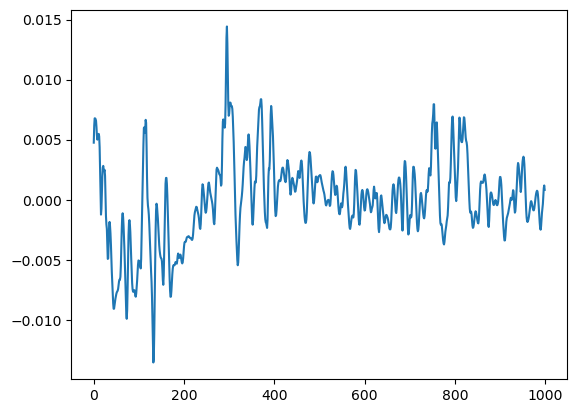

In [27]:
drr_train_filted = r_filted/r_filted.mean(0)-1
drr_train_filted = np.nan_to_num(drr_train_filted)
# plt.plot(drr_train_filted[:,34,23])
plt.plot(drr_train_filted.mean(-1).mean(-1))

Pixel in area VISp, on hemisphere L
 Seed on :('VISp', 'L')


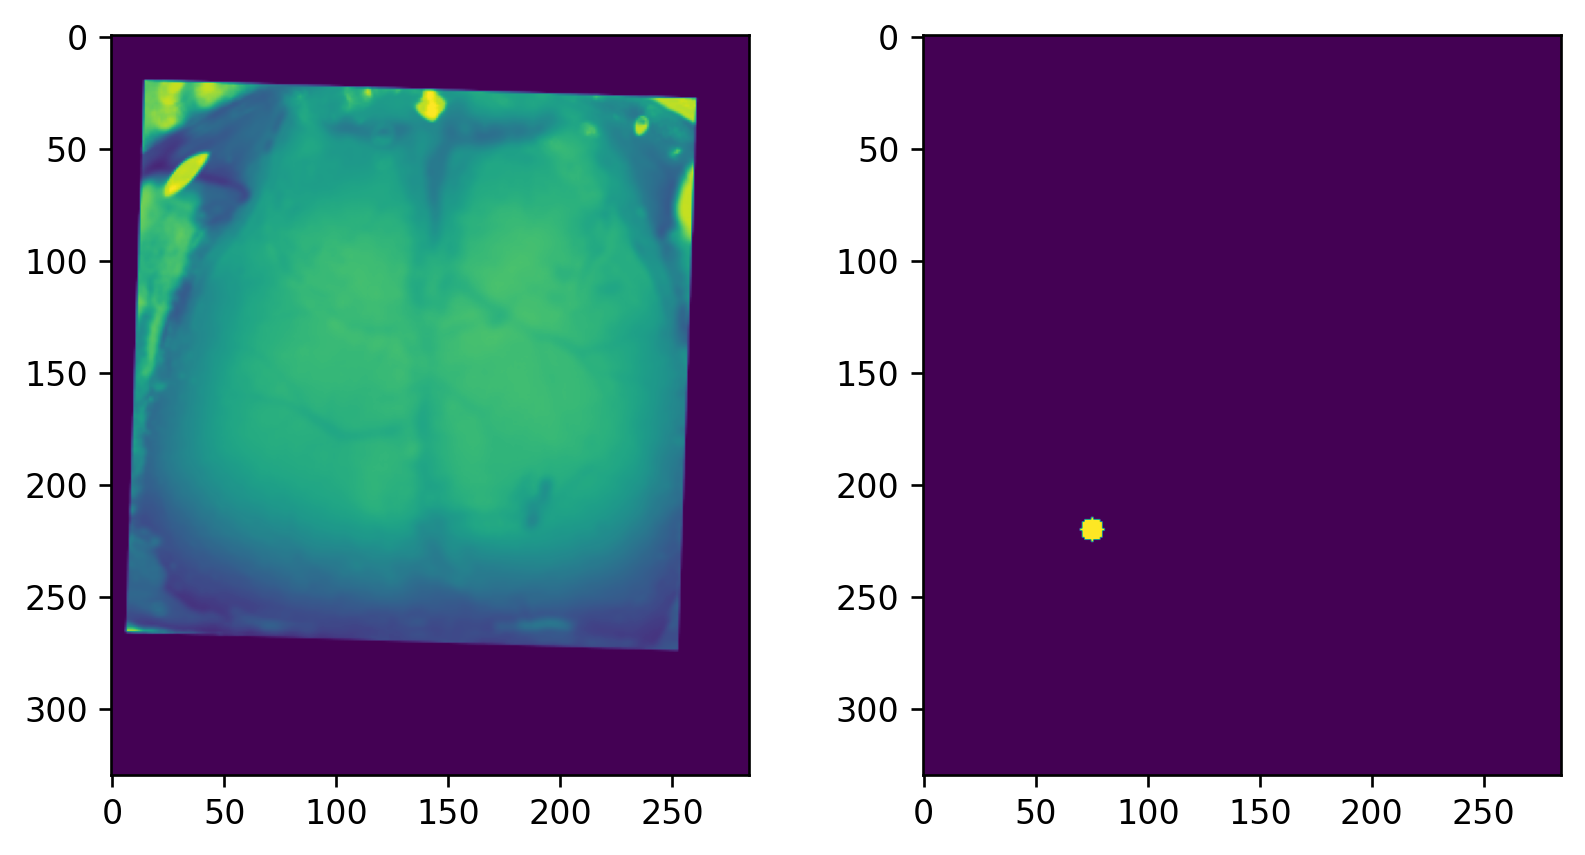

In [32]:
from Seed_Functions import *
win_len = 480
win_step = 120
seed_coords = (220,75) # height,width
r = 5 # radius of seed circle.
seed_mask = Generate_Circle_Mask(seed_coords,r,330,285)
print(f' Seed on :{MG.Pix_Label(220,75)}')

fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (8,4),dpi=240)
ax[0].imshow(r_filted.mean(0))
ax[1].imshow(seed_mask)

In [33]:
corr_wins = Seed_Window_Slide(seed_mask,drr_train_filted,win_len,win_step)

  0%|          | 0/4 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\Lulab_OI_Env\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 4/4 [00:30<00:00,  7.70s/it]


<AxesSubplot: >

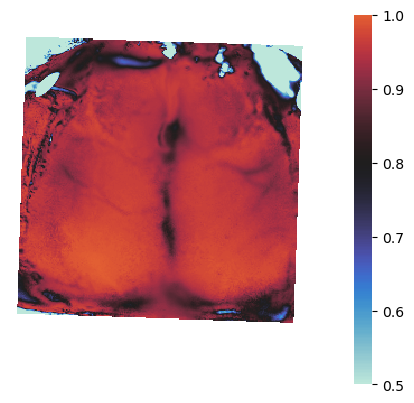

In [41]:
sns.heatmap(corr_wins[0,:,:],xticklabels=False,yticklabels=False,square=True,center=0.8,vmax = 1,vmin = 0.5)